<a href="https://colab.research.google.com/github/SecrezS/MACDforecasting/blob/main/Final_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Import required libraries

In [ ]:
# Import required libraries

!pip install pycaret yellowbrick
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns
import pycaret
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import HuberRegressor
from sklearn.svm import SVR
from yellowbrick.regressor import PredictionError

# Download and extract the libta-lib binaries
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1

# Download and extract the Python wrapper for TA-Lib
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

# Import TA-Lib
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4067    0  4067    0     0   6585      0 --:--:-- --:--:-- --:--:--  6591
100  517k  100  517k    0     0   304k      0  0:00:01  0:00:01 --:--:--  723k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4055    0  4055    0     0   6537      0 --:--:-- --:--:-- --:--:--  6540
100  392k  100  392k    0     0   277k      0  0:00:01  0:00:01 --:--:--  819k


#Step 2: Data Collection and Dictionary creation

In [ ]:
# Define tickers and initialize dictionaries
tickers = ["SPY", "DIA", "QQQ", "IWM", "XLK"]

# Initialize dictionaries to store results and splits for each ticker
important_features = {}
data_splits = {}
full_feature_set = set()  # This will gather all unique features across tickers

# Step 3: Data Processing and Feature Creation for Each Ticker

In [ ]:
# Define tickers and initialize an empty dictionary to store results for each ticker
tickers = ["SPY", "DIA", "QQQ", "IWM", "XLK"]
results = {}  # Initialize the results dictionary here

for ticker in tickers:
    print(f"\nProcessing ticker: {ticker}")

    # Download historical data
    df = yf.download(ticker, start="2012-01-01", end="2024-01-01")
    df.reset_index(inplace=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

    # Adding Technical Indicators using TA-Lib
    # Calculate Relative Strength Index (RSI)
    df['RSI'] = talib.RSI(df['Adj Close'], timeperiod=14)
    df['MACD'], df['MACD_signal'], df['MACD_diff'] = talib.MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Adj Close'], timeperiod=14)
    df['bb_bbm'], df['bb_bbh'], df['bb_bbl'] = talib.BBANDS(df['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    # Keltner Channel (KC)
    df['EMA_KC'] = talib.EMA(df['Adj Close'], timeperiod=20)
    df['KC_upper'] = df['EMA_KC'] + (df['ATR'] * 1.5)
    df['KC_lower'] = df['EMA_KC'] - (df['ATR'] * 1.5)
    df['KC'] = (df['Adj Close'] - df['KC_upper']) / df['Adj Close']
    df.drop(columns=['EMA_KC', 'KC_upper', 'KC_lower'], inplace=True)

    # Donchian Channel (DC)
    df['DC_upper'] = df['High'].rolling(window=20).max()
    df['DC_lower'] = df['Low'].rolling(window=20).min()
    df['DC_middle'] = (df['DC_upper'] + df['DC_lower']) / 2

    # On-Balance Volume (OBV)
    df['OBV'] = talib.OBV(df['Adj Close'], df['Volume'])

    # Chaikin Money Flow (CMF)
    cmf_period = 20
    df['Money_Flow_Multiplier'] = ((df['Adj Close'] - df['Low']) - (df['High'] - df['Adj Close'])) / (df['High'] - df['Low'])
    df['Money_Flow_Volume'] = df['Money_Flow_Multiplier'] * df['Volume']
    df['CMF'] = df['Money_Flow_Volume'].rolling(window=cmf_period).sum() / df['Volume'].rolling(window=cmf_period).sum()

    # Stochastic Oscillator
    df['stoch_k'], df['stoch_d'] = talib.STOCH(df['High'], df['Low'], df['Adj Close'],
                                               fastk_period=14, slowk_period=3, slowk_matype=0,
                                               slowd_period=3, slowd_matype=0)

    # Average Directional Index (ADX)
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Adj Close'], timeperiod=14)

    # Create lagged features
    features_to_lag = ['Volume', 'RSI', 'MACD', 'MACD_signal',
                       'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh',
                       'bb_bbl', 'KC','DC_upper', 'DC_lower',
                       'DC_middle','OBV','CMF','stoch_k','stoch_d','ADX']
    lag_days = 20
    for col in features_to_lag:
        for lag in range(1, lag_days + 1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    df.dropna(inplace=True)

    # Drop features that are not lagged
    columns_to_drop = ['Open','High','Low','Close','Volume', 'RSI', 'MACD',
                       'MACD_signal', 'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh',
                       'bb_bbl', 'KC','DC_upper',
                       'DC_lower', 'DC_middle','OBV','CMF','Money_Flow_Multiplier',
                       'Money_Flow_Volume','stoch_k','stoch_d','ADX']

    df.drop(columns=columns_to_drop, inplace=True)
    df.fillna(method='ffill', inplace=True)

# Store the processed DataFrame in the dictionary under the ticker key
    results[ticker] = df


Processing ticker: SPY


[*********************100%***********************]  1 of 1 completed



Processing ticker: DIA


[*********************100%***********************]  1 of 1 completed



Processing ticker: QQQ


[*********************100%***********************]  1 of 1 completed



Processing ticker: IWM


[*********************100%***********************]  1 of 1 completed



Processing ticker: XLK


[*********************100%***********************]  1 of 1 completed


# Step 4: Split Data and Select Important Features for Each Ticker


Processing ticker: SPY


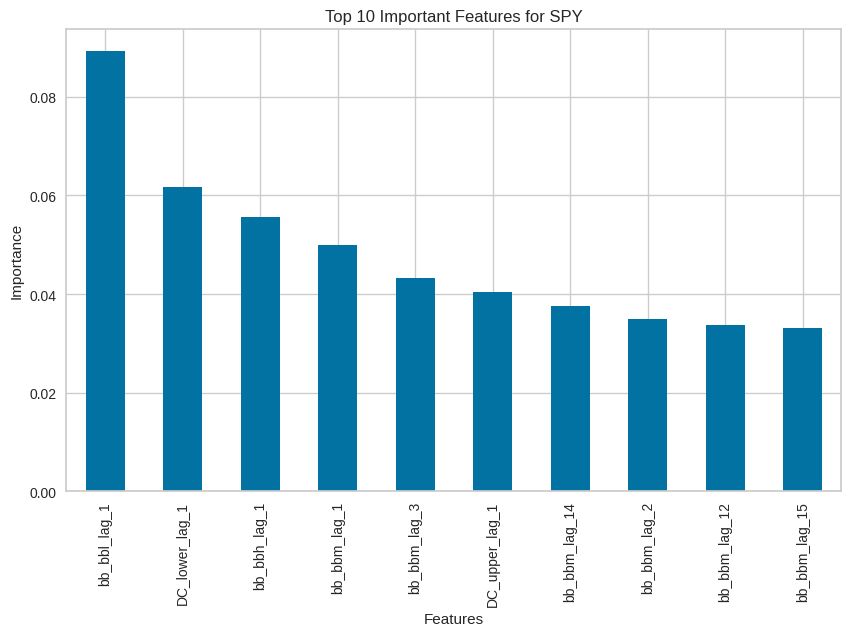


Processing ticker: DIA


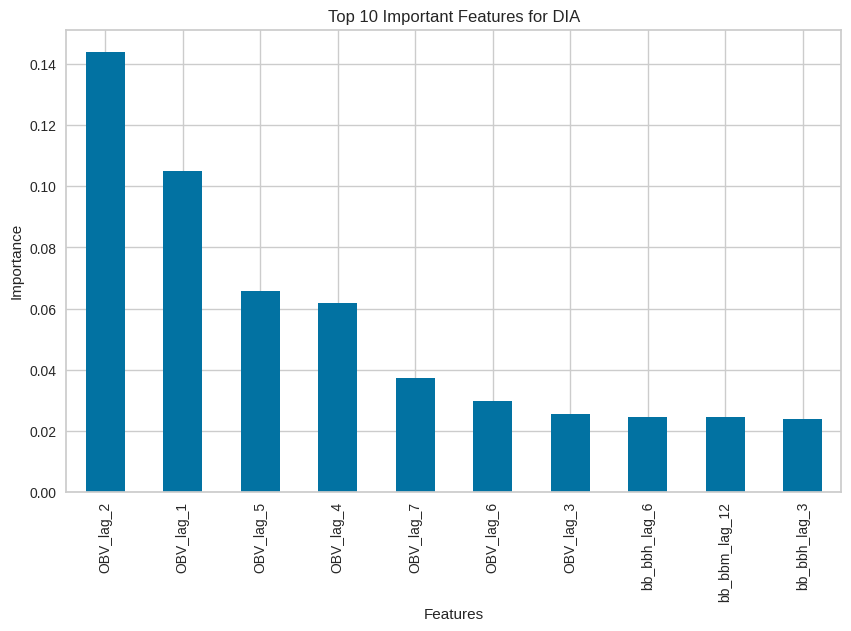


Processing ticker: QQQ


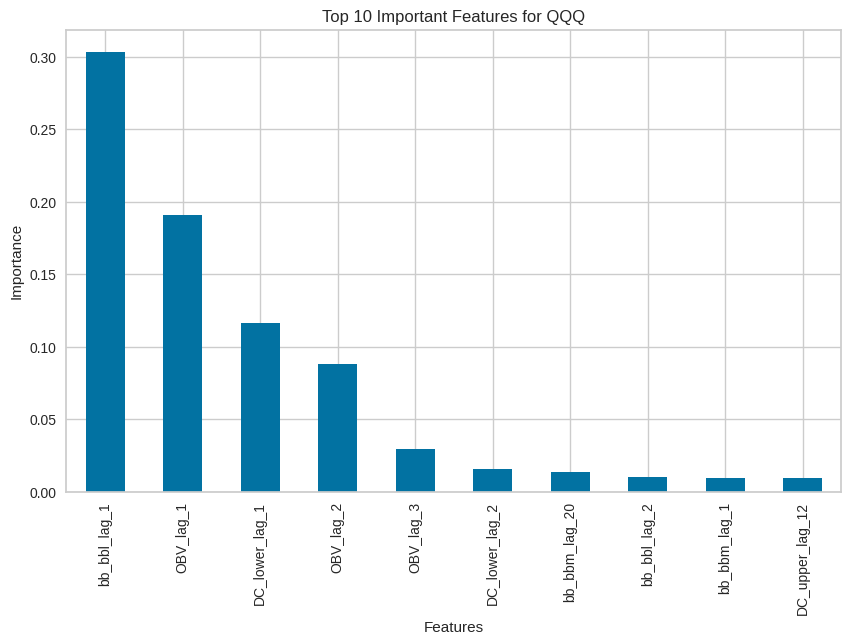


Processing ticker: IWM


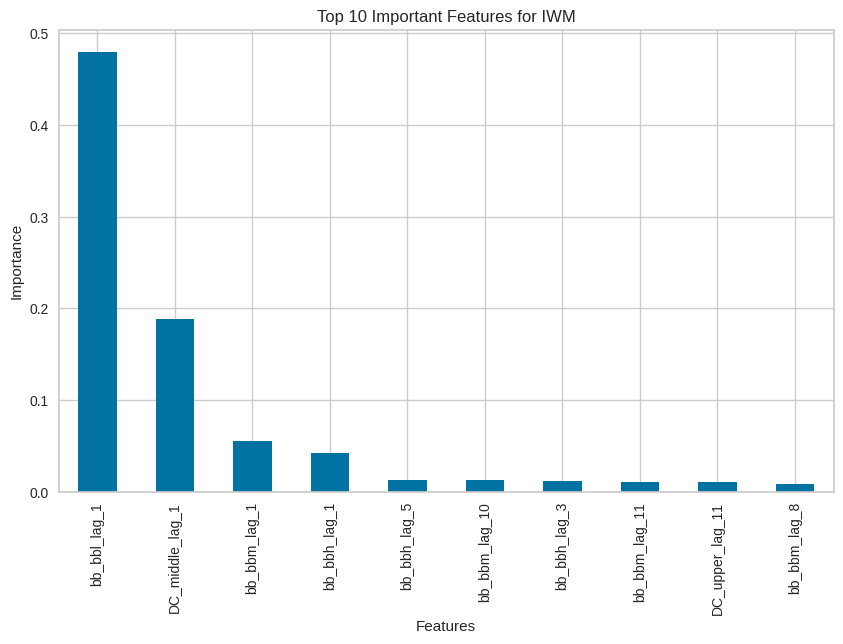


Processing ticker: XLK


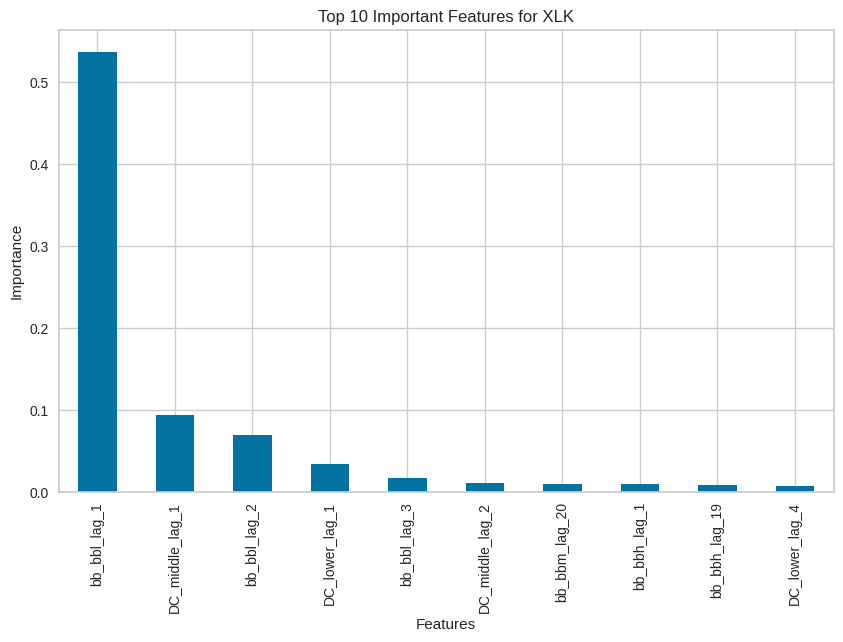

In [ ]:
# Loop through each ticker to process and identify important features
for ticker in tickers:
    print(f"\nProcessing ticker: {ticker}")

    # Retrieve processed data for the current ticker
    df = results[ticker]

    # Set 'Date' as the index for consistency and easier slicing
    df.set_index('Date', inplace=True)

    # Split data into training, validation, and test sets
    train_data = df[df.index < "2022-01-01"]
    validation_data = df[(df.index >= "2022-01-01") & (df.index < "2023-01-01")]
    test_data = df[df.index >= "2023-01-01"]

    # Store the data splits in the dictionary
    data_splits[ticker] = {
        "train": train_data,
        "validation": validation_data,
        "test": test_data
    }

    # Train RandomForest model on training data to get feature importance
    X_train = train_data.drop(columns=['Adj Close'])
    y_train = train_data['Adj Close']
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Extract and save important features
    feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    selected_features = feature_importances[feature_importances > 0.01].index.tolist()
    important_features[ticker] = selected_features
    full_feature_set.update(selected_features)  # Add to full feature set

    # Plot the top 10 important features for this ticker
    top_n = min(10, len(feature_importances))  # Only plot the top N features available
    plt.figure(figsize=(10, 6))
    feature_importances.head(top_n).plot(kind='bar')
    plt.title(f'Top {top_n} Important Features for {ticker}')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()


In [ ]:
for ticker in tickers:
    print(f"\nProcessing data alignment and feature verification for {ticker}")

    # Reindex each split with the full set of features and target column
    for split in ['train', 'validation', 'test']:
        data_splits[ticker][split] = data_splits[ticker][split].reindex(
            columns=full_feature_set.union(['Adj Close']), fill_value=0
        )


Processing data alignment and feature verification for SPY

Processing data alignment and feature verification for DIA

Processing data alignment and feature verification for QQQ

Processing data alignment and feature verification for IWM

Processing data alignment and feature verification for XLK


# Step 3: PyCaret Model Training for Each Ticker

In [ ]:
pycaret_results = {}

for ticker in tickers:
    print(f"\nRunning PyCaret model for {ticker}")

    # Retrieve selected features and target for the current ticker
    selected_features = important_features[ticker]
    available_features = data_splits[ticker]['train'].columns.intersection(selected_features + ['Adj Close'])
    train_data = data_splits[ticker]['train'][available_features]

    # Setup PyCaret with time series strategy
    regression_setup = setup(
        data=train_data,
        target='Adj Close',
        fold_strategy='timeseries',
        fold=5,
        session_id=42,
        data_split_shuffle=False,
        fold_shuffle=False,
        verbose=False
    )

    # Compare models and store the best model
    best_model = compare_models(sort='RMSE')
    pycaret_results[ticker] = {'best_model': best_model}


Running PyCaret model for SPY


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,2.1832,10.3994,2.9983,0.8527,0.0158,0.0115,1.4140
ridge,Ridge Regression,2.1997,10.4499,3.0119,0.8526,0.0159,0.0117,0.0340
br,Bayesian Ridge,2.2160,10.5005,3.0154,0.8524,0.0159,0.0117,0.0540
huber,Huber Regressor,2.3584,11.8763,3.1919,0.8377,0.0169,0.0125,0.0800
en,Elastic Net,2.6811,15.0136,3.6050,0.7981,0.0189,0.0141,0.0420
lasso,Lasso Regression,2.7728,15.9163,3.7279,0.7860,0.0196,0.0147,0.0380
llar,Lasso Least Angle Regression,2.7870,16.2107,3.7534,0.7825,0.0198,0.0147,0.0320
par,Passive Aggressive Regressor,3.2413,20.5982,4.2628,0.7361,0.0224,0.0172,0.0320
omp,Orthogonal Matching Pursuit,3.4879,20.6964,4.3435,0.7377,0.0228,0.0184,0.0300
et,Extra Trees Regressor,12.3491,254.0800,14.5238,-1.4739,0.0775,0.0632,0.6000


Processing:   0%|          | 0/81 [00:00<?, ?it/s]


Running PyCaret model for DIA


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,1.5231,4.7457,1.9946,0.9027,0.0121,0.0093,0.0340
en,Elastic Net,2.2049,9.3786,2.8177,0.8161,0.0170,0.0134,0.0360
lasso,Lasso Regression,2.2329,9.4374,2.8436,0.8142,0.0172,0.0136,0.0360
lr,Linear Regression,3.0907,18.5924,3.8808,0.6518,0.0230,0.0186,0.0360
llar,Lasso Least Angle Regression,4.5936,42.4415,5.1073,0.2015,0.0320,0.0284,0.0300
et,Extra Trees Regressor,11.2371,239.8536,12.9549,-1.6427,0.0794,0.0658,0.5640
rf,Random Forest Regressor,11.6444,246.8214,13.3748,-1.7999,0.0823,0.0685,1.8720
dt,Decision Tree Regressor,11.8554,260.7705,13.5594,-1.8912,0.0839,0.0700,0.0520
xgboost,Extreme Gradient Boosting,12.0948,270.7022,13.8477,-1.9625,0.0851,0.0707,0.6760
gbr,Gradient Boosting Regressor,12.1260,262.8356,13.9105,-1.9917,0.0856,0.0712,0.8540


Processing:   0%|          | 0/81 [00:00<?, ?it/s]


Running PyCaret model for QQQ


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lar,Least Angle Regression,2.6454,12.2480,3.3883,0.7033,0.0334,0.0255,0.0260
ridge,Ridge Regression,2.7905,12.7463,3.4098,0.6953,0.0333,0.0273,0.0300
en,Elastic Net,2.9475,13.9543,3.5581,0.6762,0.0345,0.0288,0.0280
lasso,Lasso Regression,3.1034,15.9459,3.7199,0.6308,0.0367,0.0308,0.0320
llar,Lasso Least Angle Regression,3.1121,15.9560,3.7260,0.6270,0.0369,0.0310,0.0260
rf,Random Forest Regressor,12.7893,246.7596,14.6856,-2.8394,0.1372,0.1121,1.0320
lightgbm,Light Gradient Boosting Machine,13.0841,243.0003,14.8547,-3.0641,0.1399,0.1159,0.2580
et,Extra Trees Regressor,13.1451,246.8554,14.9603,-3.0843,0.1407,0.1161,0.4800
gbr,Gradient Boosting Regressor,13.4098,258.4384,15.2594,-3.2061,0.1426,0.1176,0.2720
ada,AdaBoost Regressor,13.7990,272.7832,15.6356,-3.4230,0.1465,0.1210,0.1600


Processing:   0%|          | 0/81 [00:00<?, ?it/s]


Running PyCaret model for IWM


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,1.3781,3.3947,1.7835,0.9275,0.0158,0.0123,0.0260
br,Bayesian Ridge,1.3806,3.4033,1.7862,0.9273,0.0159,0.0123,0.0520
ridge,Ridge Regression,1.4113,3.5087,1.8194,0.9244,0.0162,0.0126,0.0260
huber,Huber Regressor,1.5781,4.5754,2.0658,0.9035,0.0184,0.0141,0.1100
en,Elastic Net,2.2103,9.1179,2.8944,0.8106,0.0256,0.0197,0.0420
lasso,Lasso Regression,2.3044,10.0674,3.0426,0.7907,0.0269,0.0205,0.0340
llar,Lasso Least Angle Regression,2.3349,10.2908,3.0800,0.7863,0.0272,0.0207,0.0560
par,Passive Aggressive Regressor,3.0100,15.0608,3.6754,0.6833,0.0329,0.0270,0.0580
omp,Orthogonal Matching Pursuit,3.6665,24.4676,4.7244,0.4867,0.0414,0.0325,0.0460
dt,Decision Tree Regressor,8.6977,123.3882,10.1027,-1.7618,0.0906,0.0748,0.0420


Processing:   0%|          | 0/81 [00:00<?, ?it/s]


Running PyCaret model for XLK


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.7874,1.3005,1.0344,0.8293,0.0227,0.0177,0.0240
br,Bayesian Ridge,0.7905,1.3011,1.0361,0.8290,0.0228,0.0178,0.0300
ridge,Ridge Regression,0.8273,1.2980,1.0529,0.8250,0.0234,0.0190,0.0380
huber,Huber Regressor,0.8030,1.3938,1.0677,0.8147,0.0236,0.0180,0.0680
omp,Orthogonal Matching Pursuit,1.1433,2.2092,1.4128,0.6215,0.0340,0.0280,0.0260
par,Passive Aggressive Regressor,1.2210,2.3837,1.4639,0.6001,0.0331,0.0277,0.0260
en,Elastic Net,1.7446,6.0323,2.0494,-0.2272,0.0560,0.0473,0.0260
llar,Lasso Least Angle Regression,1.8942,7.0464,2.1934,-0.4624,0.0608,0.0517,0.0240
lasso,Lasso Regression,1.8974,7.0595,2.1972,-0.4638,0.0608,0.0517,0.0260
knn,K Neighbors Regressor,4.2157,29.4438,4.9726,-2.1683,0.1135,0.0931,0.0300


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

# Step 4: Evaluate Model on Validation and Test Sets


In [ ]:
# Evaluation section
evaluation_results = {}

for ticker in tickers:
    print(f"\nEvaluating model for {ticker}")

    # Retrieve the best model and selected features
    best_model = pycaret_results[ticker]['best_model']
    selected_features = important_features[ticker]

    # Collect all columns used during training for this model
    model_expected_features = list(data_splits[ticker]['train'].columns)

    # Prepare validation and test data with model-expected features, filling missing ones with 0
    validation_data = data_splits[ticker]['validation'].reindex(columns=model_expected_features, fill_value=0)
    test_data = data_splits[ticker]['test'].reindex(columns=model_expected_features, fill_value=0)

    # Separate the target variable
    validation_y = validation_data.pop('Adj Close')
    test_y = test_data.pop('Adj Close')

    # Tune the best model before finalizing
    tuned_model = tune_model(best_model, optimize='RMSE', fold=5)

    # Finalize the model after tuning
    finalized_model = finalize_model(tuned_model)

    # Store the finalized model in pycaret_results to use it consistently later
    pycaret_results[ticker]['finalized_model'] = finalized_model

    # Evaluate on validation set
    validation_predictions = predict_model(finalized_model, data=validation_data)
    val_rmse = np.sqrt(mean_squared_error(validation_y, validation_predictions['prediction_label']))
    val_r2 = r2_score(validation_y, validation_predictions['prediction_label'])

    # Evaluate on test set
    test_predictions = predict_model(finalized_model, data=test_data)
    test_rmse = np.sqrt(mean_squared_error(test_y, test_predictions['prediction_label']))
    test_r2 = r2_score(test_y, test_predictions['prediction_label'])

    # Store results, including the features used in the model
    evaluation_results[ticker] = {
        'validation_rmse': val_rmse,
        'validation_r2': val_r2,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'features_used': model_expected_features  # Stores the features used in the model
    }

    # Output the evaluation metrics
    print(f"{ticker} - Validation RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")
    print(f"{ticker} - Test RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")
    print(f"{ticker} - Features used in model: {model_expected_features}\n")


Evaluating model for SPY


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4516,0.3055,0.5527,0.9328,0.0179,0.0150
1,0.5658,0.4970,0.7050,0.7737,0.0188,0.0156
2,0.8684,1.5248,1.2348,0.7380,0.0321,0.0228
3,0.6629,0.6376,0.7985,0.9714,0.0156,0.0131
4,1.3883,3.5378,1.8809,0.7307,0.0293,0.0221
Mean,0.7874,1.3005,1.0344,0.8293,0.0227,0.0177
Std,0.3301,1.1942,0.4802,0.1020,0.0067,0.0040


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 2 candidates, totalling 10 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


SPY - Validation RMSE: 16.7082, R²: 0.6058
SPY - Test RMSE: 9.1763, R²: 0.8546
SPY - Features used in model: ['bb_bbm_lag_6', 'bb_bbm_lag_1', 'DC_lower_lag_2', 'bb_bbh_lag_7', 'bb_bbh_lag_11', 'bb_bbh_lag_17', 'DC_upper_lag_12', 'bb_bbl_lag_3', 'bb_bbh_lag_13', 'OBV_lag_4', 'Adj Close', 'bb_bbm_lag_15', 'bb_bbm_lag_5', 'DC_upper_lag_8', 'OBV_lag_2', 'bb_bbh_lag_9', 'bb_bbm_lag_11', 'bb_bbh_lag_3', 'DC_middle_lag_2', 'bb_bbh_lag_1', 'bb_bbm_lag_3', 'bb_bbm_lag_10', 'DC_upper_lag_1', 'DC_upper_lag_5', 'bb_bbh_lag_8', 'bb_bbl_lag_2', 'bb_bbh_lag_20', 'bb_bbh_lag_10', 'bb_bbh_lag_19', 'bb_bbm_lag_9', 'OBV_lag_5', 'OBV_lag_6', 'bb_bbh_lag_5', 'bb_bbm_lag_7', 'OBV_lag_7', 'DC_upper_lag_11', 'DC_upper_lag_18', 'bb_bbl_lag_1', 'OBV_lag_3', 'bb_bbm_lag_12', 'bb_bbm_lag_13', 'bb_bbh_lag_4', 'bb_bbm_lag_2', 'DC_lower_lag_1', 'bb_bbm_lag_14', 'DC_middle_lag_1', 'bb_bbm_lag_20', 'bb_bbh_lag_6', 'OBV_lag_9', 'DC_upper_lag_4', 'bb_bbm_lag_17', 'OBV_lag_1', 'bb_bbh_lag_14']


Evaluating model for DIA


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3932,0.2383,0.4881,0.9475,0.0160,0.0132
1,0.5375,0.4730,0.6877,0.7847,0.0185,0.0149
2,0.9626,2.3910,1.5463,0.5892,0.0394,0.0257
3,0.8377,1.0993,1.0485,0.9508,0.0200,0.0164
4,1.1889,2.3012,1.5170,0.8248,0.0238,0.0187
Mean,0.7840,1.3005,1.0575,0.8194,0.0235,0.0178
Std,0.2871,0.8994,0.4269,0.1326,0.0083,0.0043


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


DIA - Validation RMSE: 13.3656, R²: 0.2672
DIA - Test RMSE: 7.9470, R²: 0.6124
DIA - Features used in model: ['bb_bbm_lag_6', 'bb_bbm_lag_1', 'DC_lower_lag_2', 'bb_bbh_lag_7', 'bb_bbh_lag_11', 'bb_bbh_lag_17', 'DC_upper_lag_12', 'bb_bbl_lag_3', 'bb_bbh_lag_13', 'OBV_lag_4', 'Adj Close', 'bb_bbm_lag_15', 'bb_bbm_lag_5', 'DC_upper_lag_8', 'OBV_lag_2', 'bb_bbh_lag_9', 'bb_bbm_lag_11', 'bb_bbh_lag_3', 'DC_middle_lag_2', 'bb_bbh_lag_1', 'bb_bbm_lag_3', 'bb_bbm_lag_10', 'DC_upper_lag_1', 'DC_upper_lag_5', 'bb_bbh_lag_8', 'bb_bbl_lag_2', 'bb_bbh_lag_20', 'bb_bbh_lag_10', 'bb_bbh_lag_19', 'bb_bbm_lag_9', 'OBV_lag_5', 'OBV_lag_6', 'bb_bbh_lag_5', 'bb_bbm_lag_7', 'OBV_lag_7', 'DC_upper_lag_11', 'DC_upper_lag_18', 'bb_bbl_lag_1', 'OBV_lag_3', 'bb_bbm_lag_12', 'bb_bbm_lag_13', 'bb_bbh_lag_4', 'bb_bbm_lag_2', 'DC_lower_lag_1', 'bb_bbm_lag_14', 'DC_middle_lag_1', 'bb_bbm_lag_20', 'bb_bbh_lag_6', 'OBV_lag_9', 'DC_upper_lag_4', 'bb_bbm_lag_17', 'OBV_lag_1', 'bb_bbh_lag_14']


Evaluating model for QQQ


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5561,0.5171,0.7191,0.8862,0.0229,0.0187
1,0.5189,0.4310,0.6565,0.8038,0.0176,0.0143
2,0.9945,2.7466,1.6573,0.5280,0.0422,0.0266
3,0.8357,1.0949,1.0464,0.9510,0.0200,0.0163
4,1.1864,2.2993,1.5163,0.8250,0.0237,0.0187
Mean,0.8183,1.4178,1.1191,0.7988,0.0253,0.0189
Std,0.2550,0.9415,0.4066,0.1448,0.0087,0.0041


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


QQQ - Validation RMSE: 12.5387, R²: 0.8518
QQQ - Test RMSE: 10.3048, R²: 0.9222
QQQ - Features used in model: ['bb_bbm_lag_6', 'bb_bbm_lag_1', 'DC_lower_lag_2', 'bb_bbh_lag_7', 'bb_bbh_lag_11', 'bb_bbh_lag_17', 'DC_upper_lag_12', 'bb_bbl_lag_3', 'bb_bbh_lag_13', 'OBV_lag_4', 'Adj Close', 'bb_bbm_lag_15', 'bb_bbm_lag_5', 'DC_upper_lag_8', 'OBV_lag_2', 'bb_bbh_lag_9', 'bb_bbm_lag_11', 'bb_bbh_lag_3', 'DC_middle_lag_2', 'bb_bbh_lag_1', 'bb_bbm_lag_3', 'bb_bbm_lag_10', 'DC_upper_lag_1', 'DC_upper_lag_5', 'bb_bbh_lag_8', 'bb_bbl_lag_2', 'bb_bbh_lag_20', 'bb_bbh_lag_10', 'bb_bbh_lag_19', 'bb_bbm_lag_9', 'OBV_lag_5', 'OBV_lag_6', 'bb_bbh_lag_5', 'bb_bbm_lag_7', 'OBV_lag_7', 'DC_upper_lag_11', 'DC_upper_lag_18', 'bb_bbl_lag_1', 'OBV_lag_3', 'bb_bbm_lag_12', 'bb_bbm_lag_13', 'bb_bbh_lag_4', 'bb_bbm_lag_2', 'DC_lower_lag_1', 'bb_bbm_lag_14', 'DC_middle_lag_1', 'bb_bbm_lag_20', 'bb_bbh_lag_6', 'OBV_lag_9', 'DC_upper_lag_4', 'bb_bbm_lag_17', 'OBV_lag_1', 'bb_bbh_lag_14']


Evaluating model for IWM

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4516,0.3055,0.5527,0.9328,0.0179,0.0150
1,0.5658,0.4970,0.7050,0.7737,0.0188,0.0156
2,0.8684,1.5248,1.2348,0.7380,0.0321,0.0228
3,0.6629,0.6376,0.7985,0.9714,0.0156,0.0131
4,1.3883,3.5378,1.8809,0.7307,0.0293,0.0221
Mean,0.7874,1.3005,1.0344,0.8293,0.0227,0.0177
Std,0.3301,1.1942,0.4802,0.1020,0.0067,0.0040


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 2 candidates, totalling 10 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


IWM - Validation RMSE: 7.1706, R²: 0.6672
IWM - Test RMSE: 5.1735, R²: 0.6561
IWM - Features used in model: ['bb_bbm_lag_6', 'bb_bbm_lag_1', 'DC_lower_lag_2', 'bb_bbh_lag_7', 'bb_bbh_lag_11', 'bb_bbh_lag_17', 'DC_upper_lag_12', 'bb_bbl_lag_3', 'bb_bbh_lag_13', 'OBV_lag_4', 'Adj Close', 'bb_bbm_lag_15', 'bb_bbm_lag_5', 'DC_upper_lag_8', 'OBV_lag_2', 'bb_bbh_lag_9', 'bb_bbm_lag_11', 'bb_bbh_lag_3', 'DC_middle_lag_2', 'bb_bbh_lag_1', 'bb_bbm_lag_3', 'bb_bbm_lag_10', 'DC_upper_lag_1', 'DC_upper_lag_5', 'bb_bbh_lag_8', 'bb_bbl_lag_2', 'bb_bbh_lag_20', 'bb_bbh_lag_10', 'bb_bbh_lag_19', 'bb_bbm_lag_9', 'OBV_lag_5', 'OBV_lag_6', 'bb_bbh_lag_5', 'bb_bbm_lag_7', 'OBV_lag_7', 'DC_upper_lag_11', 'DC_upper_lag_18', 'bb_bbl_lag_1', 'OBV_lag_3', 'bb_bbm_lag_12', 'bb_bbm_lag_13', 'bb_bbh_lag_4', 'bb_bbm_lag_2', 'DC_lower_lag_1', 'bb_bbm_lag_14', 'DC_middle_lag_1', 'bb_bbm_lag_20', 'bb_bbh_lag_6', 'OBV_lag_9', 'DC_upper_lag_4', 'bb_bbm_lag_17', 'OBV_lag_1', 'bb_bbh_lag_14']


Evaluating model for XLK


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4516,0.3055,0.5527,0.9328,0.0179,0.0150
1,0.5658,0.4970,0.7050,0.7737,0.0188,0.0156
2,0.8684,1.5248,1.2348,0.7380,0.0321,0.0228
3,0.6629,0.6376,0.7985,0.9714,0.0156,0.0131
4,1.3883,3.5378,1.8809,0.7307,0.0293,0.0221
Mean,0.7874,1.3005,1.0344,0.8293,0.0227,0.0177
Std,0.3301,1.1942,0.4802,0.1020,0.0067,0.0040


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 2 candidates, totalling 10 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


XLK - Validation RMSE: 5.5150, R²: 0.8113
XLK - Test RMSE: 4.8789, R²: 0.9234
XLK - Features used in model: ['bb_bbm_lag_6', 'bb_bbm_lag_1', 'DC_lower_lag_2', 'bb_bbh_lag_7', 'bb_bbh_lag_11', 'bb_bbh_lag_17', 'DC_upper_lag_12', 'bb_bbl_lag_3', 'bb_bbh_lag_13', 'OBV_lag_4', 'Adj Close', 'bb_bbm_lag_15', 'bb_bbm_lag_5', 'DC_upper_lag_8', 'OBV_lag_2', 'bb_bbh_lag_9', 'bb_bbm_lag_11', 'bb_bbh_lag_3', 'DC_middle_lag_2', 'bb_bbh_lag_1', 'bb_bbm_lag_3', 'bb_bbm_lag_10', 'DC_upper_lag_1', 'DC_upper_lag_5', 'bb_bbh_lag_8', 'bb_bbl_lag_2', 'bb_bbh_lag_20', 'bb_bbh_lag_10', 'bb_bbh_lag_19', 'bb_bbm_lag_9', 'OBV_lag_5', 'OBV_lag_6', 'bb_bbh_lag_5', 'bb_bbm_lag_7', 'OBV_lag_7', 'DC_upper_lag_11', 'DC_upper_lag_18', 'bb_bbl_lag_1', 'OBV_lag_3', 'bb_bbm_lag_12', 'bb_bbm_lag_13', 'bb_bbh_lag_4', 'bb_bbm_lag_2', 'DC_lower_lag_1', 'bb_bbm_lag_14', 'DC_middle_lag_1', 'bb_bbm_lag_20', 'bb_bbh_lag_6', 'OBV_lag_9', 'DC_upper_lag_4', 'bb_bbm_lag_17', 'OBV_lag_1', 'bb_bbh_lag_14']




Plotting predictions for SPY


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,14.0476,279.1643,16.7082,0.6058,0.0414,0.0358


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,7.5180,84.2051,9.1763,0.8546,0.0220,0.0181


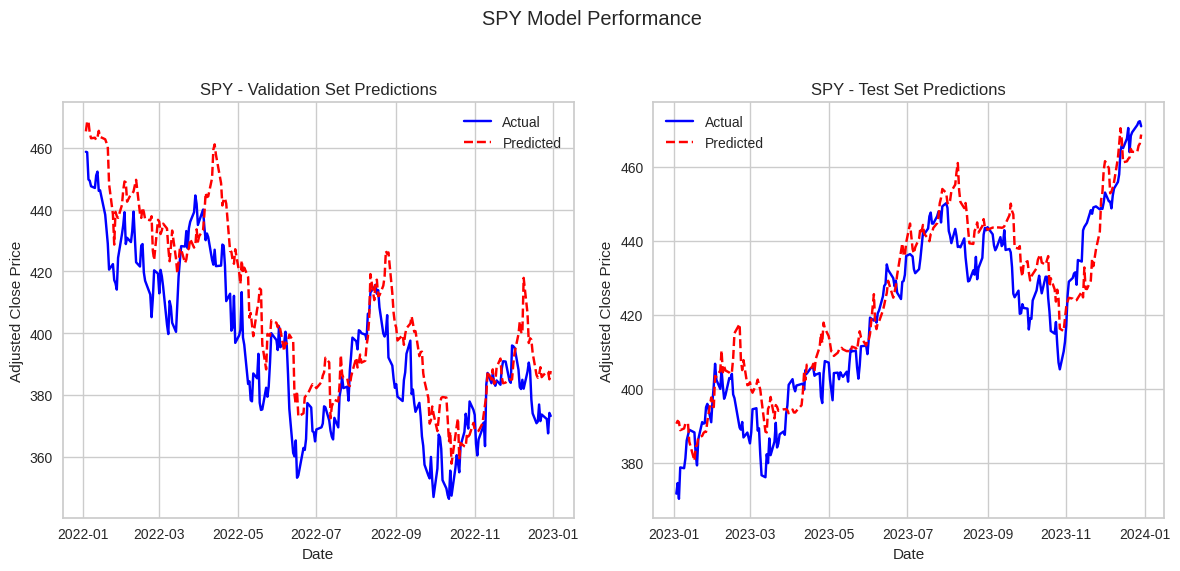


Plotting predictions for DIA


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,11.4339,178.6397,13.3656,0.2672,0.0418,0.0367


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,6.7696,63.1548,7.9470,0.6124,0.0239,0.0206


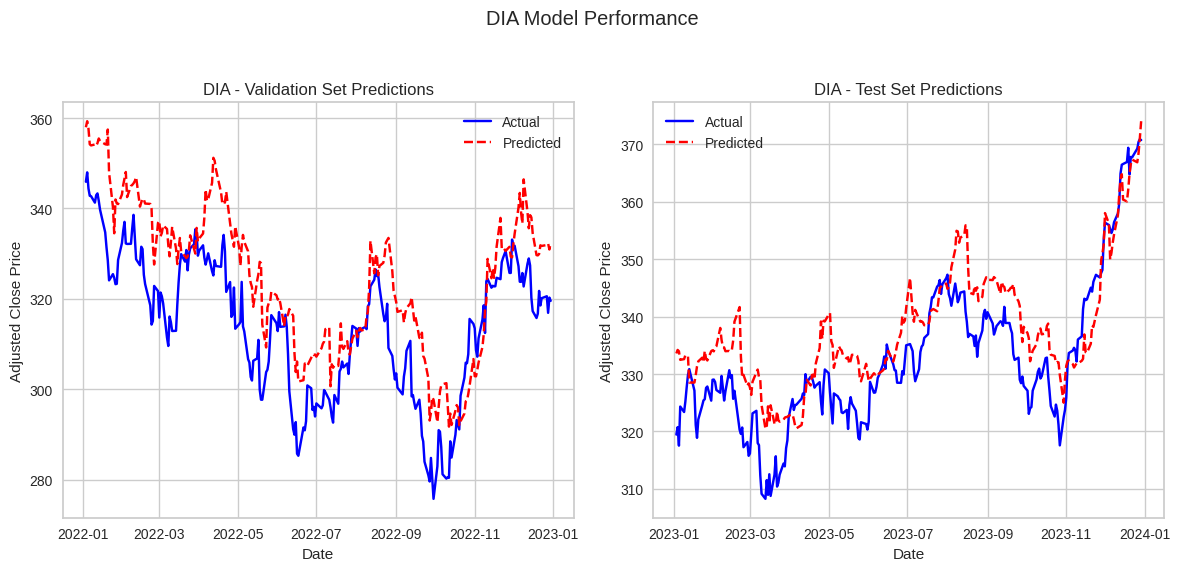


Plotting predictions for QQQ


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,10.1112,157.2201,12.5387,0.8518,0.0396,0.0328


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,8.4466,106.1891,10.3048,0.9222,0.0305,0.0248


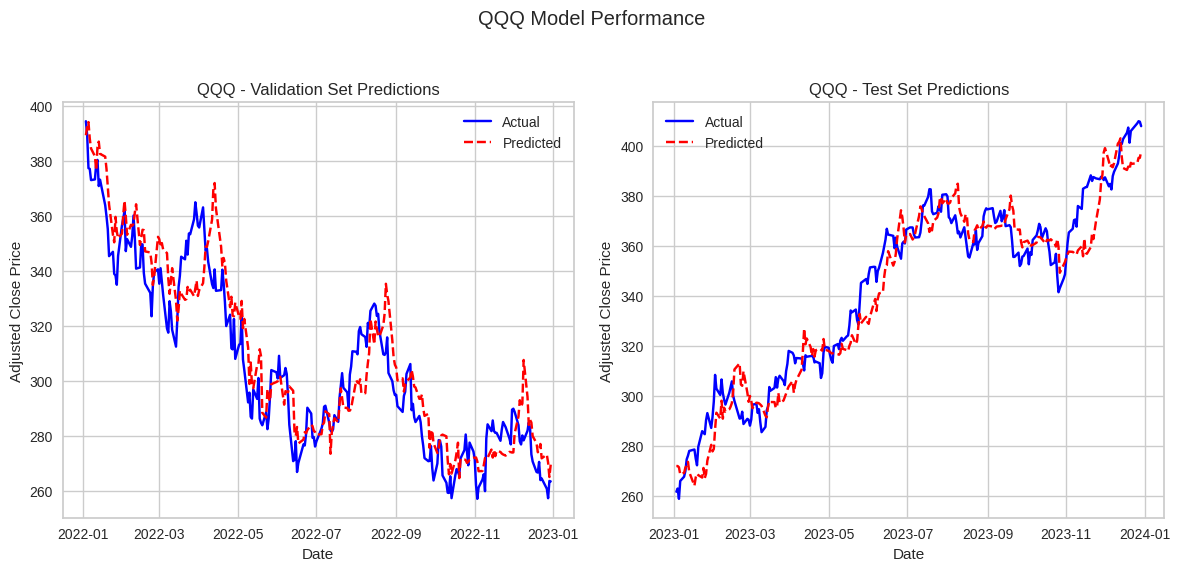


Plotting predictions for IWM


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,6.0080,51.4171,7.1706,0.6672,0.0389,0.0335


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,4.3451,26.7651,5.1735,0.6561,0.0283,0.0241


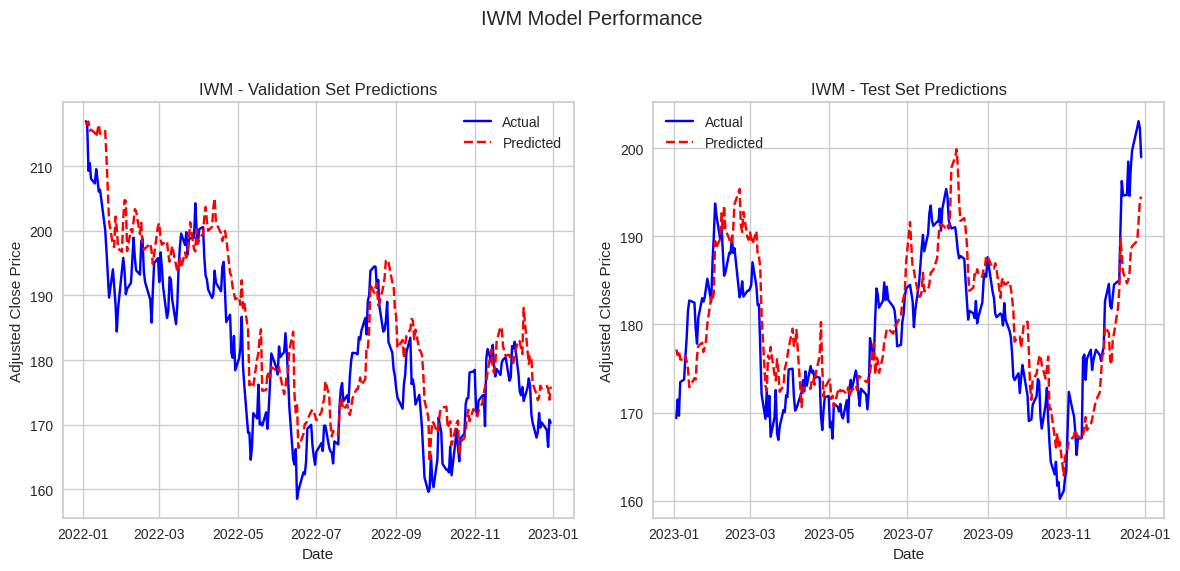


Plotting predictions for XLK


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,4.6126,30.4147,5.5150,0.8113,0.0395,0.0338


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.9690,23.8038,4.8789,0.9234,0.0307,0.0250


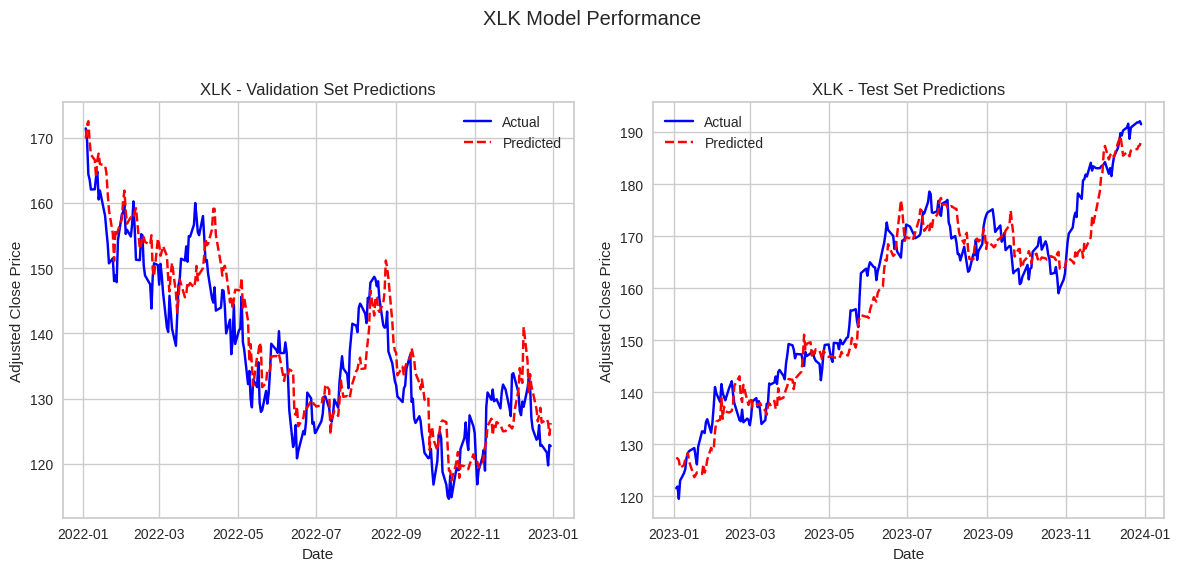

In [ ]:
# Plotting section
for ticker in tickers:
    print(f"\nPlotting predictions for {ticker}")

    # Retrieve the finalized model from pycaret_results
    finalized_model = pycaret_results[ticker]['finalized_model']

    # Retrieve actual and predicted values for validation and test sets
    validation_y = data_splits[ticker]['validation']['Adj Close']
    test_y = data_splits[ticker]['test']['Adj Close']

    # Generate predictions using the finalized model
    validation_predictions = predict_model(finalized_model, data=data_splits[ticker]['validation']).set_index(validation_y.index)
    test_predictions = predict_model(finalized_model, data=data_splits[ticker]['test']).set_index(test_y.index)

    # Plot for Validation Set
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(validation_y.index, validation_y, label='Actual', color='blue')
    plt.plot(validation_predictions.index, validation_predictions['prediction_label'],
             label='Predicted', color='red', linestyle='--')
    plt.title(f'{ticker} - Validation Set Predictions')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()

    # Plot for Test Set
    plt.subplot(1, 2, 2)
    plt.plot(test_y.index, test_y, label='Actual', color='blue')
    plt.plot(test_predictions.index, test_predictions['prediction_label'],
             label='Predicted', color='red', linestyle='--')
    plt.title(f'{ticker} - Test Set Predictions')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()

    plt.suptitle(f'{ticker} Model Performance')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
